In [1]:
pip install transformers seaborn accelerate datasets 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch


In [3]:

splits = {'train': 'train.jsonl', 'test': 'test.jsonl'}
# df= pd.read_json("hf://datasets/SetFit/yelp_review_full/"+ splits["train"],lines=True)
df= pd.read_json("hf://datasets/SetFit/yelp_review_full/"+ splits["test"],lines=True)
# df = pd.concat([train, test])
# Display the first few rows of the dataset
df.head()

label                                               text label_text
0      0  I got 'new' tires from them and within two wee...     1 star
1      0  Don't waste your time.  We had two different p...     1 star
2      0  All I can say is the worst! We were the only 2...     1 star
3      0  I have been to this restaurant twice and was d...     1 star
4      0  Food was NOT GOOD at all! My husband & I ate h...     1 star

In [4]:
df['count'] = df['text'].apply(lambda x: len(x.split()))

<Figure size 1000x1000 with 0 Axes>

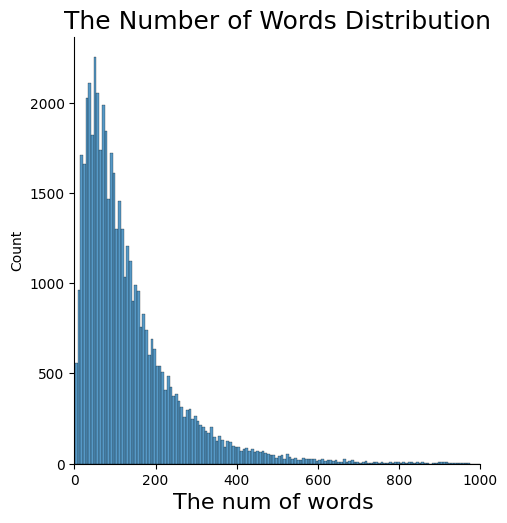

In [5]:
plt.figure(figsize= (10, 10))

sns.displot(df['count'])

plt.xlim(0, 1000)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

In [6]:
category_count = df['label_text'].value_counts()

categories = category_count.index

categories

Index(['1 star', '3 stars', '2 star', '4 stars', '5 stars'], dtype='object', name='label_text')

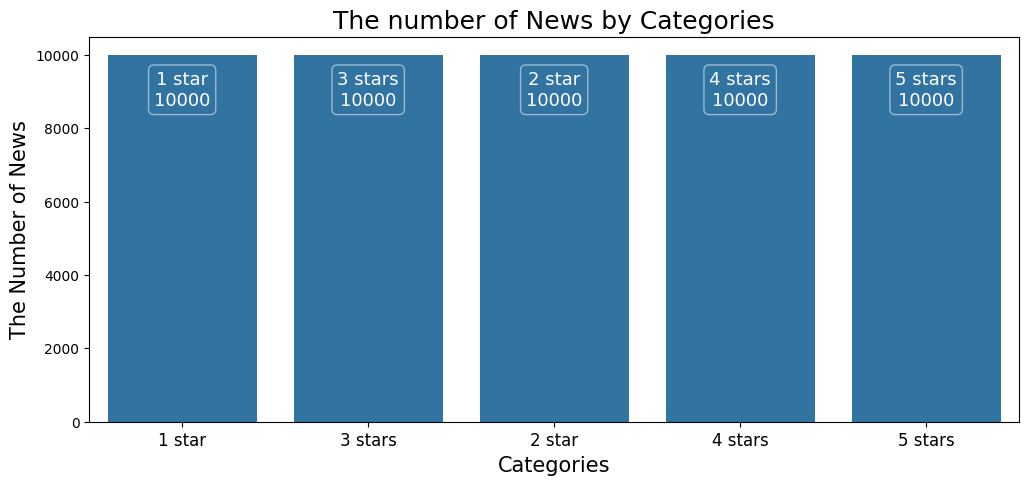

In [7]:
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )

plt.xlabel('Categories', size = 15)

plt.ylabel('The Number of News', size= 15)

plt.xticks(size = 12)

plt.title("The number of News by Categories" , size = 18)

plt.show()

In [8]:
# df['encoded_text'] = df['category'].astype('category').cat.codes
# df

In [9]:
data_texts = df['text'].to_list()

data_labels = df['label'].to_list()

In [10]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size = 0.2, random_state = 0 )


# train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size = 0.01, random_state = 0 )

In [11]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation = True, padding = True ,  max_length=512)

val_encodings = tokenizer(val_texts, truncation = True, padding = True , max_length=512)

In [12]:
import torch

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings  # Dictionary of tokenized inputs
        self.labels = labels        # Corresponding labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Retrieve input encodings for a given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])  # Add labels
        return item

# Creating datasets
train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)




In [14]:
# Load model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train the model
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


TrainOutput(global_step=5000, training_loss=0.952101842880249, metrics={'train_runtime': 1846.9106, 'train_samples_per_second': 21.658, 'train_steps_per_second': 2.707, 'total_flos': 5298979430400000.0, 'train_loss': 0.952101842880249, 'epoch': 1.0})

In [15]:
trainer.evaluate()

{'eval_loss': 0.830126166343689,
 'eval_runtime': 123.0163,
 'eval_samples_per_second': 81.29,
 'eval_steps_per_second': 10.161,
 'epoch': 1.0}

In [16]:
save_directory = "./distlbert_fine_tuned_model"

model.save_pretrained(save_directory)

tokenizer.save_pretrained(save_directory)

('./distlbert_fine_tuned_model/tokenizer_config.json',
 './distlbert_fine_tuned_model/special_tokens_map.json',
 './distlbert_fine_tuned_model/vocab.txt',
 './distlbert_fine_tuned_model/added_tokens.json')

In [21]:
df['text'][110]

'I got \'new\' tires from them and within two weeks got a flat. I took my car to a local mechanic to see if i could get the hole patched, but they said the reason I had a flat was because the previous patch had blown - WAIT, WHAT? I just got the tire and never needed to have it patched? This was supposed to be a new tire. \\nI took the tire over to Flynn\'s and they told me that someone punctured my tire, then tried to patch it. So there are resentful tire slashers? I find that very unlikely. After arguing with the guy and telling him that his logic was far fetched he said he\'d give me a new tire \\"this time\\". \\nI will never go back to Flynn\'s b/c of the way this guy treated me and the simple fact that they gave me a used tire!'

In [32]:
df['label'][1100]

3

In [28]:
def predict_class(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to("cuda")

    with torch.no_grad():
        outputs = model(**inputs)

    prediction_value = torch.argmax(outputs.logits, dim=1).item()

    
    return f"Predicted Category: {prediction_value}"

# Example usage (do not run)the browser's clipboard. Please make sure you have granted access for this website to
print(predict_class(df['text'][0]))


Predicted Category: 0


In [ ]:
import shutil

# Specify the folder to be zipped
folder_path = "distilbert_fine_tuned_model"  # Replace with your actual folder name
zip_name = "distilbert_fine_tuned_model.zip"  # Desired zip file name

# Create a zip archive
shutil.make_archive(zip_name.replace('.zip', ''), 'zip', folder_path)

print(f"Folder '{folder_path}' has been zipped as '{zip_name}'.")
